# Setup

## Imports

In [2]:
import h5py 
import mat73
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_1samp, ttest_ind

# from LDA import LDA
# from PlotLDAMetrics import PlotLDAMetrics

## Load File Paths

In [3]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['06']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/Subject{sub}',
        'out_path_plots': f'Plots/Subject{sub}'
    }

In [4]:
raw_file = h5py.File(file_paths['06']['raw_path'])
setup_data = mat73.loadmat(file_paths['06']['setup_path'])

out_path_plots = file_paths['06']['out_path_plots']
out_path_metrics = file_paths['06']['out_path_metrics']

In [5]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [6]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [7]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [8]:
data = np.load(file_paths['06']['data_path'])
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Matplotlib Settings

In [9]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

## Create Frequency Bands

In [10]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

In [11]:
f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

# Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

## Via Functions

In [200]:
def train_LDA_model(data, y, channel:int, time:int, time_resolution:int):
    """
    Trains several LDA models (via cross-validation) at a specific channel and time point. Averages the values of the feature vector across a time window of length specified by time_resolution.

    Parameters
    ----------
    data : arr, required 
        The data that the LDA model is to be trained on
    
    y : arr, required
        The labels that the LDA model is to be trained on
    
    channel : int, required
        The particular channel from the data that the LDA model is to be trained on
    
    time : int, required
        The particular timepoint from the data that the LDA model is to be trained on
    
    time_resolution : int, required
        The length of the time window that the feature vector is to be averaged across
    
    Returns
    -------
    mean_score : float
        The mean score of the LDA estimators after cross-validation
    
    std_score : float
        The standard deviation of the scores of the LDA estimators after cross-validation
    
    dval : arr
        The decision values of the LDA estimators when evaluated on their respective test sets
    
    t_stat : float
        The t-statistic of the decision values, with the null hypothesis being that the population mean is zero
    
    low_bet_avg_power : arr
        The average value at each frequency for all trials with a low bet

    high_bet_avg_power : arr
        The average value at each frequency for all trials with a high bet

    diff_avg_power : arr
        The difference in the average values at each frequency for high and low bets

    lda_coeff : arr
        The coefficients of the LDA estimator with the highest score 
    """

    num_trials, num_channels, num_freqs, num_timesteps = data.shape

    # Checks that inputted value for time resolution is valid
    if not(num_timesteps % time_resolution == 0):
        raise Exception("Invalid time resolution size, num_timesteps % resolution > 0")
    
    X = data[:, channel, :, time:time+time_resolution].mean(-1)

    low_bet_avg_power = X[np.where(y == 0)]
    high_bet_avg_power = X[np.where(y == 1)]
    diff_avg_power = np.abs(high_bet_avg_power.mean(0)) - np.abs(low_bet_avg_power.mean(0))

    # Using RepeatedKFold() for training LDA, but this method does not produce reproducible results! Could possibly average the test scores from all the 5 estimators
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

    estimators = []
    scores = []
    dval = np.zeros(num_trials)

    for train, test in rkf.split(X):
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        lda.fit(X[train], y[train])
        estimators.append(lda)
        scores.append(lda.score(X[test], y[test]))  
        dval[test] = np.dot(X[test], lda.coef_.T).T[0] + lda.intercept_

    lda_coef = estimators[scores.index(max(scores))].coef_[0]

    # Using cross_validate() function for training LDA
    # lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    # cv_results = cross_validate(lda, X, y, cv = 5, return_estimator=True, return_indices=True) # Possibly pass in a CVSplitter into the cv argument, possibly pass in rkf (?)

    # estimators = cv_results['estimator']
    # scores = cv_results['test_score']

    mean_score = np.mean(scores)
    std_score = np.std(scores)

    t_stat, p_vals = ttest_1samp(dval, popmean=0) # perform 1-sided t-test on decision values corresponding to high bet

    return mean_score, std_score, dval, t_stat, p_vals, low_bet_avg_power, high_bet_avg_power, diff_avg_power, lda_coef

In [201]:
def calculate_LDA_metrics(data, y, time_resolution):
    """
    Calculates the LDA metrics for each channel and timepoint

    Parameters
    ----------
    data : arr, required 
        The data that the LDA model is to be trained on
    
    y : arr, required
        The labels that the LDA model is to be trained on

    time_resolution : int, required
        The length of the time window that the feature vector is to be averaged across

    Returns
    -------
    metrics : dict
        A dictionary containing the mean scores, standard deviation of scores, decision values, t statistics, 
        low and high bet average powers, difference in the high and low bet average powers, LDA coefficients, and time resolution that the LDA was trained on 
    """

    # Code to train LDA model for all channels and timepoints for Subject 6
    num_trials, num_channels, num_freqs, num_timesteps = data.shape
    rescaled_timesteps = int(num_timesteps/time_resolution)

    # A dictionary that stores all the metrics of the LDA model
    metrics = {
        'Mean Scores' : np.zeros((num_channels, rescaled_timesteps)),
        'STD Scores' : np.zeros((num_channels,rescaled_timesteps)),
        'Decision Values' : np.zeros((num_channels, rescaled_timesteps, num_trials)),
        'T Stats' : np.zeros((num_channels,rescaled_timesteps)),
        'P Vals' : np.zeros((num_channels,rescaled_timesteps)),
        'Low Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, len(y) - int(y.sum()), num_freqs)),
        'High Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, int(y.sum()), num_freqs)),
        'Difference Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, num_freqs)),
        'LDA Coefficients' : np.zeros((num_channels, rescaled_timesteps, num_freqs)),
        'Time Resolution' : time_resolution
    }

    for channel in range(num_channels):
        for time in range(rescaled_timesteps):
            metrics['Mean Scores'][channel, time], metrics['STD Scores'][channel, time], metrics['Decision Values'][channel, time], metrics['T Stats'][channel, time], metrics['P Vals'][channel, time], metrics['Low Bet Average Powers'][channel, time], metrics['High Bet Average Powers'][channel, time], metrics['Difference Bet Average Powers'][channel, time], metrics['LDA Coefficients'][channel, time] = train_LDA_model(data=data, y=y, channel=channel, time=time*time_resolution, time_resolution=time_resolution)
    
    return metrics

In [213]:
metrics = calculate_LDA_metrics(f_band_data,y,time_resolution=5)

### Save Metrics

In [13]:
with open(out_path_metrics+'_LDA_metrics.csv', 'w', newline="") as fp:
    writer = csv.DictWriter(fp, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

### Reshuffling of Data

In [77]:
# Returns an array with shuffled y-values, ensures that high bet ratio is consistent with thay expected for the particular card value

def shuffle_y(y):
    """
    Randomly shuffle the elements of y to be in different locations.

    Parameters
    ----------
        y : arr, required
    The labels that the LDA model is to be trained on

    Returns
    -------
        y_shuffled : arr
    An array with the elements of y randomly shuffled to be in different locations.
    """
    
    np.random.seed()
    # Get the locations for each particular card value
    card_value_indices = []
    for i in [2,4,6,8,10]:
        card_value_indices.append(np.where(subject_cards == i)[0])

    y_shuffled = np.zeros(y.shape)

    # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
    for indices in card_value_indices:
        temp = indices
        num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
        for j in range(num_high_bets):
            if np.any(temp):
                # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                rand = np.random.choice(temp)
                y_shuffled[rand] = 1
                rand_index = np.where(temp == rand)[0]
                temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
        y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

    return y_shuffled

In [15]:
def get_shuffled_t_stats(data, y, time_resolution:int):
  """
  Shuffles the y-labels, trains an LDA model on the data and shuffled y-labels, and returns the t-stats of the decision value of the LDA model

  Parameters
  ----------
  data : arr, required
    The data the LDA model is to be trained on

  y : arr, required
    The labels that the LDA model is to be trained on

  time_resolution : int, required
    The number of timesteps for the time window to be computed by
  
  Returns
  -------
  metrics['T Stats] : arr
    An array of t-stats computed from the decision value of the LDA model for each channel/timepoint
  """
  y_shuffled = shuffle_y(y)
  metrics = calculate_LDA_metrics(data=data, y=y_shuffled, time_resolution=time_resolution)
    
  return metrics['T Stats']

## Via Classes

In [35]:
class LDA(object):
    def __init__(
            self
            ):
        self.mean_scores = []
        self.std_scores = []
        self.dvals = []
        self.t_stats = []
        self.p_vals = []
        self.low_bet_avg_powers = []
        self.high_bet_avg_powers = []
        self.diff_avg_powers = []
        self.lda_coefs = []

    @property
    def num_trials(self):
        return self.__num_trials

    @property
    def num_channels(self):
        return self.__num_channels

    @property
    def num_freqs(self):
        return self.__num_freqs
    
    @property
    def num_timesteps(self):
        return self.__num_timesteps
    
    @property
    def time_resolution(self):
        return self.__time_resolution
    
    @property
    def rescaled_timesteps(self):
        return self.__rescaled_timesteps
    
    @property
    def elec_areas(self):
        return self.__elec_areas
    
    @property
    def elec_names(self):
        return self.__elec_names

    def _create_X(self, data, channel, time):
        if type(time) == int:
            X = data[:, channel, :, time:time+self.__time_resolution].mean(-1)
        else:
            X = data[:, channel, :, time]

        return X
    
    def _reshape_attributes(self, new_shape:tuple):
        for attr_name in self.__dict__.keys():
            if not attr_name.startswith('_'):
                setattr(self, attr_name, np.reshape(getattr(self, attr_name), new_shape))

    def _set_attributes(self, data, setup_data, **kwargs):
        self.__elec_areas = setup_data['elec_area']
        self.__elec_names = setup_data['elec_name']

        self.__num_trials, self.__num_channels, self.__num_freqs, self.__num_timesteps = data.shape

        if not(self.__num_timesteps % kwargs['time_resolution'] == 0):
            raise Exception("Invalid time resolution size, num_timesteps % resolution must equal 0")
        else:
            self.__time_resolution = kwargs['time_resolution']
            self.__rescaled_timesteps = int(self.__num_timesteps/kwargs['time_resolution'])

    def _filter_channels(self):
        self._filtered_elec_areas_idxs = [i for i,ea in enumerate(self.__elec_areas) if ea not in ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid','lesion L','ventricle L','ventricle R']]
        temp = [self.__elec_areas[i] for i in self._filtered_elec_areas_idxs]
        self.__elec_areas = temp
    
    def _train(self, X, y):
        low_bet_avg_powers = X[np.where(y == 0)].mean(0)
        high_bet_avg_powers = X[np.where(y == 1)].mean(0)

        self.high_bet_avg_powers.append(high_bet_avg_powers)
        self.low_bet_avg_powers.append(low_bet_avg_powers)
        self.diff_avg_powers.append(high_bet_avg_powers - low_bet_avg_powers)

        # Using RepeatedKFold() for training LDA
        rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

        estimators = []
        scores = []
        dval = np.zeros(self.__num_trials)

        for train, test in rkf.split(X):
            lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
            lda.fit(X[train], y[train])
            estimators.append(lda)
            scores.append(lda.score(X[test], y[test]))
            dval[test] = np.dot(X[test], lda.coef_.T).T[0] + lda.intercept_

        self.dvals.append(dval)
        self.lda_coefs.append(estimators[scores.index(max(scores))].coef_[0])
        self.mean_scores.append(np.mean(scores))
        
        self.std_scores.append(np.std(scores))

        t_stat, p_val = ttest_1samp(dval, popmean=0) # perform 1-sided t-test on decision values corresponding to high bet
        self.t_stats.append(t_stat)
        self.p_vals.append(p_val)

    def create_cluster_idxs(self, threshold):
        if self.t_stats.shape == (self.__num_channels, self.__rescaled_timesteps, 1):
            cluster_idxs = []

            for channel in range(self.__num_channels):
                ch_cluster_idxs = []
                threshold_idxs = [i for i, t_stat in enumerate(self.t_stats[channel].flatten()) if np.abs(t_stat) > threshold]
                temp_cluster_idxs = [threshold_idxs[0]]
            
                # Groups consecutive clusters together
                for i in range(len(threshold_idxs) - 1):
                    if threshold_idxs[i+1] - threshold_idxs[i] == 1:
                        temp_cluster_idxs.append(threshold_idxs[i+1])
                    else:
                        ch_cluster_idxs.append(temp_cluster_idxs)
                        temp_cluster_idxs = [threshold_idxs[i+1]]
                
                if len(temp_cluster_idxs) != 0:
                    ch_cluster_idxs.append(temp_cluster_idxs)
                
                cluster_idxs.append(ch_cluster_idxs)
            
            return cluster_idxs
        else:
            Exception('Cannot create clusters with these attributes, make sure shape of attributes is (num_channels, rescaled_timesteps, 1)')

    def compute_t_stat_clusters(self, threshold):
        t_stat_sums = []

        for channel in range(self.num_channels):
            temp_t_stat_sums = []
            for arr in self.create_cluster_idxs(threshold)[channel]:
                temp_t_stat_sums.append(self.t_stats[channel][arr].sum())
            
            t_stat_sums.append(temp_t_stat_sums)
        
        return t_stat_sums

    def train_per_channel_and_timestep(self, data, y, setup_data, time_resolution):
        self._set_attributes(data, setup_data, time_resolution=time_resolution)

        for channel in range(self.__num_channels):
            for time in range(self.__rescaled_timesteps):
                X = self._create_X(data, channel, time*self.__time_resolution)
                self._train(X, y)

        self._reshape_attributes((self.__num_channels,self.__rescaled_timesteps,-1))

    def train_on_all_channels(self, data, y, setup_data, time_resolution, filter_channels:bool = False, custom_channels = None):
        self._set_attributes(data, setup_data, time_resolution=time_resolution)

        for time in range(self.__rescaled_timesteps):
            if filter_channels:
                self._filter_channels()
                X = self._create_X(data, self._filtered_elec_areas_idxs, time*self.__time_resolution)
            elif not custom_channels == None:
                X = self._create_X(data, custom_channels, time*self.__time_resolution)
            else:
                X = self._create_X(data, np.arange(0,self.__num_channels), time*self.__time_resolution)

            X_reshaped = X.reshape(self.__num_trials,-1)
            self._train(X_reshaped,y)
        
        self._reshape_attributes((self.__rescaled_timesteps,-1))
    
    def train_on_all_timesteps(self, data, y, setup_data):
        self._set_attributes(data, setup_data)

        for channel in range(self.__num_channels):
            X = self._create_X(data, channel, np.arange(self.__num_timesteps))
            X_reshaped = X.reshape(self.__num_trials, -1)
            self._train(X_reshaped, y)
        
        self._reshape_attributes((self.__num_channels,-1))

In [48]:
class ShuffledLDA(LDA):
    def __init__(self,
                 setup_data):
        super().__init__()
        self._get_hand(setup_data)

        
    def _get_hand(self, setup_data):
        bets = setup_data['filters']['bets']
        good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

        self.__sub_hand = setup_data['filters']['card1'][good_trials] # get the subject's card hand for the good trials
    
    def _shuffle_y(self, y):
        """
        Randomly shuffle the elements of y to be in different locations.

        Parameters
        ----------
            y : arr, required
        The labels that the LDA model is to be trained on

        Returns
        -------
            y_shuffled : arr
        An array with the elements of y randomly shuffled to be in different locations.
        """
        
        np.random.seed()

        print('Shuffling!')

        # Get the locations for each particular card value
        card_value_indices = []
        for i in [2,4,6,8,10]:
            card_value_indices.append(np.where(self.__sub_hand == i)[0])

        y_shuffled = np.zeros(y.shape)

        # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
        for indices in card_value_indices:
            temp = indices
            num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
            for _ in range(num_high_bets):
                if np.any(temp):
                    # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                    rand = np.random.choice(temp)
                    y_shuffled[rand] = 1
                    rand_index = np.where(temp == rand)[0]
                    temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
            y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

        return y_shuffled
    
    def train_per_channel_and_timestep(self, data, y, setup_data, time_resolution):
        y_shuffled = self._shuffle_y(y)
        super().train_per_channel_and_timestep(data, y_shuffled, setup_data=setup_data, time_resolution=time_resolution)

    def compute_t_stat_clusters(self, ref_estimator, threshold):
        t_stat_sums = []

        for channel in range(self.num_channels):
            temp_t_stat_sums = []
            for arr in ref_estimator.create_cluster_idxs(threshold)[channel]:
                temp_t_stat_sums.append(self.t_stats[channel][arr].sum())
            
            t_stat_sums.append(temp_t_stat_sums)
        
        return t_stat_sums

In [105]:
lda = LDA()

In [41]:
lda.train_per_channel_and_timestep(f_band_data,y,setup_data=setup_data, time_resolution=5)

In [106]:
lda.train_on_all_channels(f_band_data, y, setup_data=setup_data, time_resolution= 5, filter_channels= True)

In [42]:
shuffled_lda = ShuffledLDA(setup_data)

In [43]:
shuffled_lda.train_per_channel_and_timestep(f_band_data,y,setup_data=setup_data, time_resolution=5)

Shuffling!


# Multiprocessing

In [49]:
def get_shuffled_t_stats(data, y, setup_data,  time_resolution, threshold, ref_estimator):
    shuffled_lda = ShuffledLDA(setup_data)
    shuffled_lda.train_per_channel_and_timestep(data, y, setup_data = setup_data, time_resolution=time_resolution)
    return shuffled_lda.compute_t_stat_clusters(ref_estimator, threshold)

In [50]:
from multiprocessing import Pool

n_processes = 20

if __name__ == '__main__':
    with Pool(n_processes) as p:
        results = p.starmap(get_shuffled_t_stats, [(f_band_data, y, setup_data, 5, 12, lda)] * 100)
        p.close()

Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!
Shuffling!

# Visualization of Model Performance

## Via Functions

In [120]:
def sort_scores(data, metrics:dict, elec_names, elec_areas, filter_channels:bool):
    """
    Sorts the channels (highest to lowest) by their peak LDA model score

    Parameters
    ----------
    data : arr, required 
        The data that the model was trained on
    
    metrics : dict, required
        The dictionary containing the metrics of the LDA model
    
    elec_names : arr, required
        The names of the electrodes corresponding to the data
    
    elec_areas : arr, required 
        The areas of the electrodes corresponding to the data
    
    filter_channels : bool, rquired
        Whether or not to filter out selected channels 

    Returns
    -------
    mean_scores_max_sorted : arr
        An array of sorted LDA scores (highest to lowest) with their respective channels and timepoints
    
    elec_names_sorted : arr
        An array of sorted electrode names corresponding to their respective LDA scores

    elec_areas_sorted : arr
        An array of sorted electrode areas corresponding to their respective LDA scores  
    """

    num_channels = data.shape[1]
    mean_scores_max = np.zeros((num_channels,3))

    for channel in range(num_channels):
        mean_scores_max[channel, 0] = int(channel) # store the channel index
        mean_scores_max[channel, 1] = list(metrics['Mean Scores'][channel]).index(max(metrics['Mean Scores'][channel])) # the time point at which the maximum mean score occurs
        mean_scores_max[channel, 2] = max(metrics['Mean Scores'][channel]) # value of the maximum mean score in a particular channel for all time points

    if filter_channels == True:
        elec_areas_filtered_idx = [i for i,ea in enumerate(elec_areas) if ea not in ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid','lesion L','ventricle L','ventricle R']]
        sorted_indices = mean_scores_max[elec_areas_filtered_idx,2].argsort()[::-1]
        mean_scores_max_sorted = mean_scores_max[elec_areas_filtered_idx][sorted_indices]
        elec_names_sorted = elec_names[np.int_(mean_scores_max_sorted[:, 0])]
        elec_areas_sorted = elec_areas[np.int_(mean_scores_max_sorted[:, 0])]
        
    else:
        sorted_indices = mean_scores_max[:,2].argsort()[::-1]
        mean_scores_max_sorted = mean_scores_max[sorted_indices]
        elec_names_sorted = elec_names[sorted_indices]
        elec_areas_sorted = elec_areas[sorted_indices]

    return mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted

In [121]:
def plot_sorted_scores(metrics:dict, mean_scores_max_sorted, elec_areas, out_path:str):
    """
    Plots all the peak LDA model scores (sorted from highest to lowest) for each channel

    Parameters
    ----------
    metrics : dict, required
        The dictionary containing the metrics of the LDA model
    
    mean_scores_max_sorted : arr, required
        Array of sorted max scores of LDA model
    
    elec_areas : arr, required 
        The areas of the electrodes corresponding to the data
    
    out_path : str, rquired
        The file path the plots are saved to
    """


    num_channels = len(mean_scores_max_sorted)
    
    fig, axs = plt.subplots(3, 1, figsize=(24,24), gridspec_kw={'height_ratios' : [1,1,1]})

    axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
    axs[0].set_ylabel('Peak Mean Score')
    axs[0].set_xlabel('Channels (from most to least accurate)')
    axs[0].plot(np.arange(0,num_channels,1), mean_scores_max_sorted[:,2])

    axs[1].set_title('Scatter Plot of Peak Score of LDA Models (from greatest to least) with error bars')
    axs[1].set_ylabel('Peak Mean Score')
    axs[1].set_xlabel('Channels (from most to least accurate)')
    axs[1].scatter(np.arange(0,num_channels,1), mean_scores_max_sorted[:,2])
    axs[1].errorbar(np.arange(0,num_channels,1), mean_scores_max_sorted[:,2], yerr=metrics['STD Scores'][np.int_(mean_scores_max_sorted[:,0]),np.int_(mean_scores_max_sorted[:,1])], fmt="o")
    
    axs[2].set_title('Time of Peak Score of LDA Models')
    axs[2].set_ylabel('Time (seconds)')
    axs[2].set_xlabel('Channels (from most to least accurate)')
    time = mean_scores_max_sorted[:,1]/(20/metrics['Time Resolution']) - 3
    axs[2].scatter(np.arange(0, num_channels), time)
    axs[2].axhline(y = 0, color = 'red', alpha=0.5)

    fig.tight_layout()
    fig.savefig(out_path + f'_sorted_scores')
    
    plt.figure(figsize=(24,24))
    plt.title('Sorted Peak Score of LDA Models (from greatest to least)')
    plt.ylabel('Channel Names')
    plt.xlabel('Score')
    plt.hlines(y=np.arange(0,num_channels), xmin=0.5, xmax=mean_scores_max_sorted[:,2][::-1],
        color='blue', alpha=0.6, linewidth=2)
    plt.yticks(np.arange(0,num_channels), labels=elec_areas[::-1])

    plt.savefig(out_path + f'_sorted_scores_hline')
    

In [122]:
def plot_sorted_scores_per_channel(data, metrics:dict, mean_scores_max_sorted, num_plots:int, elec_names, elec_areas, out_path:str):
    """
    Plots the LDA score over time for each channel (sorted by highest to lowest peak score). The time of the peak score for each channel is also annotated.

    Parameters
    ----------
    data : arr, required 
        The data that the model was trained on
    
    metrics : dict, required
        The dictionary containing the metrics of the LDA model
    
    mean_scores_max_sorted : arr, required
        Array of sorted max scores of LDA model
    
    num_plots : int, requried
        The number of channels to plot
    
    elec_names : arr, required
        The names of the electrodes corresponding to the data
    
    elec_areas : arr, required 
        The areas of the electrodes corresponding to the data
    
    out_path : str, rquired
        The file path the plots are saved to
    """


    num_timesteps = data.shape[3]

    time_resolution = metrics['Time Resolution']
    rescaled_timesteps = int(num_timesteps/time_resolution)
    times = (np.arange(0, rescaled_timesteps, 1) / (20/time_resolution)) - 3 # time 0 seconds denotes when the subject starts moving (i.e. 3 seconds into the data)

    fig, axs = plt.subplots(num_plots, 1, figsize=(24, 8 * num_plots))

    for i, trial_data in enumerate(mean_scores_max_sorted[:num_plots]):
        channel, time, peak_accuracy = trial_data
        time = time/(20/time_resolution) - 3
        ax = axs[i]
        ax.plot(times[:], metrics['Mean Scores'][int(channel)])
        ax.set_title('Electrode %s in the %s' %(elec_names[i], elec_areas[i]))
        ax.set_ylabel('Score')
        ax.set_xlabel('Time (seconds)')
        # ax.tick_params(axis='both', labelsize=12)
        ax.axvline(time, color = 'red', alpha=0.5)
        ax.axvline(0, color = 'blue', alpha=0.5, ls = '--')
        ax.annotate(f'(Time: {time:.2f}s, Score: {peak_accuracy:.2f})', xy=(time + .05 ,.6), fontsize = 12)
    
    plt.savefig(out_path + f'_sorted_scores_per_channel')
    plt.show()

In [108]:
def plot_power_heatmap(data, metrics:dict, plot_metric, mean_scores_max_sorted, num_plots:int, elec_names, elec_areas, out_path:str):
    """
    Plot the heatmaps showing the metrics of the LDA models

    Parameters
    ----------
    data : arr, required 
        The data that the model was trained on
    
    metrics : dict, required
        The dictionary containing the metrics of the LDA model
    
    plot_metric : arr, required
        The metric to be plotted over the heatmap
    
    mean_scores_max_sorted : arr, required
        Array of sorted max scores of LDA model
    
    num_plots : int, requried
        The number of channels to plot
    
    elec_names : arr, required
        The names of the electrodes corresponding to the data
    
    elec_areas : arr, required 
        The areas of the electrodes corresponding to the data
    
    out_path : str, rquired
        The file path the heatmaps are saved to
    """

    num_freqs, num_timesteps = data.shape[2:]
    time_resolution = metrics['Time Resolution']
    rescaled_timesteps = int(num_timesteps/time_resolution)

    if rescaled_timesteps >= 50:
        num_xticks = int(rescaled_timesteps/2)
    else:
        num_xticks = rescaled_timesteps

    xticks = np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)
    xticklabels = np.around(np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - 3, decimals=2)

    if data.shape[2] == 5: 
        # sets the y-tick labels for EEG frequency bands
        yticks = np.arange(num_freqs)
        yticklabels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
    else:
        # sets the y-tick labels for all frequencies in data
        yticks = np.arange(num_freqs, step=2)
        yticklabels = [round(i,1) for i in np.logspace(np.log2(2),np.log2(150), num = len(yticks),base=2, dtype=np.float16)]

    for i, trial_data in enumerate(mean_scores_max_sorted[:num_plots]):
        channel, time, peak_accuracy = trial_data

        low_bet_powers = metrics['Low Bet Average Powers'][int(channel)]
        high_bet_powers = metrics['High Bet Average Powers'][int(channel)]
        diff_bet_powers = metrics['Difference Bet Average Powers'][int(channel)]
        lda_coef = metrics['LDA Coefficients'][int(channel)]

        fig, axs = plt.subplots(2, 2,figsize=(24, 20))
        
        # Plot power per frequency as a function of time, power averaged across all respective trials (high or low bet trials) 
        sns.heatmap(high_bet_powers.mean(1).T, ax=axs[0][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[0][0].set_title('Electrode %s in the %s \n High Bet Z-Scored Frequency Power (n = %s)' %(elec_names[i], elec_areas[i], high_bet_powers.shape[1]))
        axs[0][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        axs[0][0].set_xticks(xticks, labels = xticklabels)

        sns.heatmap(low_bet_powers.mean(1).T, ax=axs[0][1], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[0][1].set_title('Electrode %s in the %s \n Low Bet Z-Scored Frequency Power (n = %s)' %(elec_names[i], elec_areas[i], low_bet_powers.shape[1]))
        axs[0][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        axs[0][1].set_xticks(xticks, labels = xticklabels)

        # ax = sns.heatmap(diff_bet_powers.T, vmin=-.4, vmax=.4, cbar_kws={"label": "Frequency Power", "pad": 0.1}, cmap='PRGn')
        # ax.set_title('Electrode %s in the %s \n Difference in Frequency Power (High - Low Bet)' %(elec_names[i], elec_areas[i]))
        # ax.set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        # ax.set_xticks(xticks, labels = xticklabels)
        # ax.axvline(time, color = 'red', alpha=0.5)
        # ax.axvline(0, color = 'blue', alpha=0.25, ls = '--')
        # ax_ = ax.twinx()
        # sns.lineplot(x=np.arange(0,rescaled_timesteps), y=plot_metric[int(channel)], color='blue', ax=ax_) # Make the overlayed metric an optional variable user can select
        # ax_.set_ylabel('Mean LDA Score')

        # Plot power per frequency at a particular timestep for each respective trial (high or low bet trials)
        # sns.heatmap(low_bet_powers[int(time)].T, ax=axs[0][0], vmin=-3, vmax=3, cbar_kws={"label": "Frequency Power"}, cmap='PRGn')
        # axs[0][0].set_title('Electrode %s in the %s at time %s \n Low Bet Frequency Power' %(elec_names[i], elec_areas[i], round(time/(20/time_resolution) - 3,2)))
        # axs[0][0].set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

        # sns.heatmap(high_bet_powers[int(time)].T, ax=axs[0][1], vmin=-3, vmax=3, cbar_kws={"label": "Frequency Power"}, cmap='PRGn')
        # axs[0][1].set_title('Electrode %s in the %s at time %s \n High Bet Frequency Power' %(elec_names[i], elec_areas[i], round(time/(20/time_resolution) - 3,2)))
        # axs[0][1].set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

        # Plots the difference in power frequency for high and low bet trials
        sns.heatmap(diff_bet_powers.T, ax=axs[1][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power", "pad": 0.1}, cmap='PRGn')
        axs[1][0].set_title('Electrode %s in the %s \n Difference in Z-Scored Frequency Power (High - Low Bet)' %(elec_names[i], elec_areas[i]))
        axs[1][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        axs[1][0].set_xticks(xticks, labels = xticklabels)
        ax = axs[1][0].twinx()
        sns.lineplot(x=np.arange(0,rescaled_timesteps), y=plot_metric[int(channel)], color='blue', ax=ax) # Make the overlayed metric an optional variable user can select
        ax.set_ylabel('Mean LDA Score')
        axs[1][0].axvline(time, color = 'red', alpha=0.5)
        axs[1][0].axvline(0, color = 'blue', alpha=0.25, ls = '--')

        # Plots the LDA coefficients for each frequency band over time
        sns.heatmap(lda_coef.T, ax=axs[1][1], vmin=-1, vmax=1, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[1][1].set_title('LDA coefficient values for all frequencies \n at %s in %s' %(elec_names[i], elec_areas[i]))
        axs[1][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        axs[1][1].set_xticks(xticks, labels = xticklabels)

        for axs_ in axs:
            for ax in axs_:
                # ax.set_xticks(xticks)
                # ax.set_xticklabels(xticklabels)
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticklabels, rotation = 0)
                ax.axes.invert_yaxis()
                ax.axvline(time, color = 'red', alpha=0.5)
                ax.axvline(12, color = 'blue', alpha=0.5, ls = '--')

                for label in ax.xaxis.get_ticklabels()[1::2]:
                    label.set_visible(False)

        plt.savefig(out_path + '_heatmap_%s_%s'%(elec_names[i], elec_areas[i]))
        plt.show()

In [123]:
def plot_scores(data, metrics:dict, plot_metric, elec_names, elec_areas, num_plots:int = 10, filter_channels:bool = False, out_path_plots:str = None):
    """
    Plot the heatmaps and line graphs showing the metrics of the LDA models

    Parameters
    ----------
    data : arr, required 
        The data that the model was trained on
    
    metrics : dict, required
        The dictionary containing the metrics of the LDA model

    plot_metric : arr, required
        The metric to be plotted over the heatmap
    
    elec_names : arr, required
        The names of the electrodes corresponding to the data
    
    elec_areas : arr, required 
        The areas of the electrodes corresponding to the data

    num_plots : int, requried
        The number of channels to plot

    filter_channels : bool, required
        Whether or not to filter out selected channels 
    
    out_path_plots : str, required
        The file path the plots are saved to
    """
    
    mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted = sort_scores(data, metrics, elec_names, elec_areas, filter_channels)
    plot_sorted_scores(metrics, mean_scores_max_sorted, elec_areas_sorted, out_path_plots)
    plot_sorted_scores_per_channel(data, metrics, mean_scores_max_sorted, num_plots, elec_names_sorted, elec_areas_sorted, out_path_plots)
    plot_power_heatmap(data, metrics, plot_metric, mean_scores_max_sorted, num_plots, elec_names_sorted, elec_areas_sorted, out_path_plots)

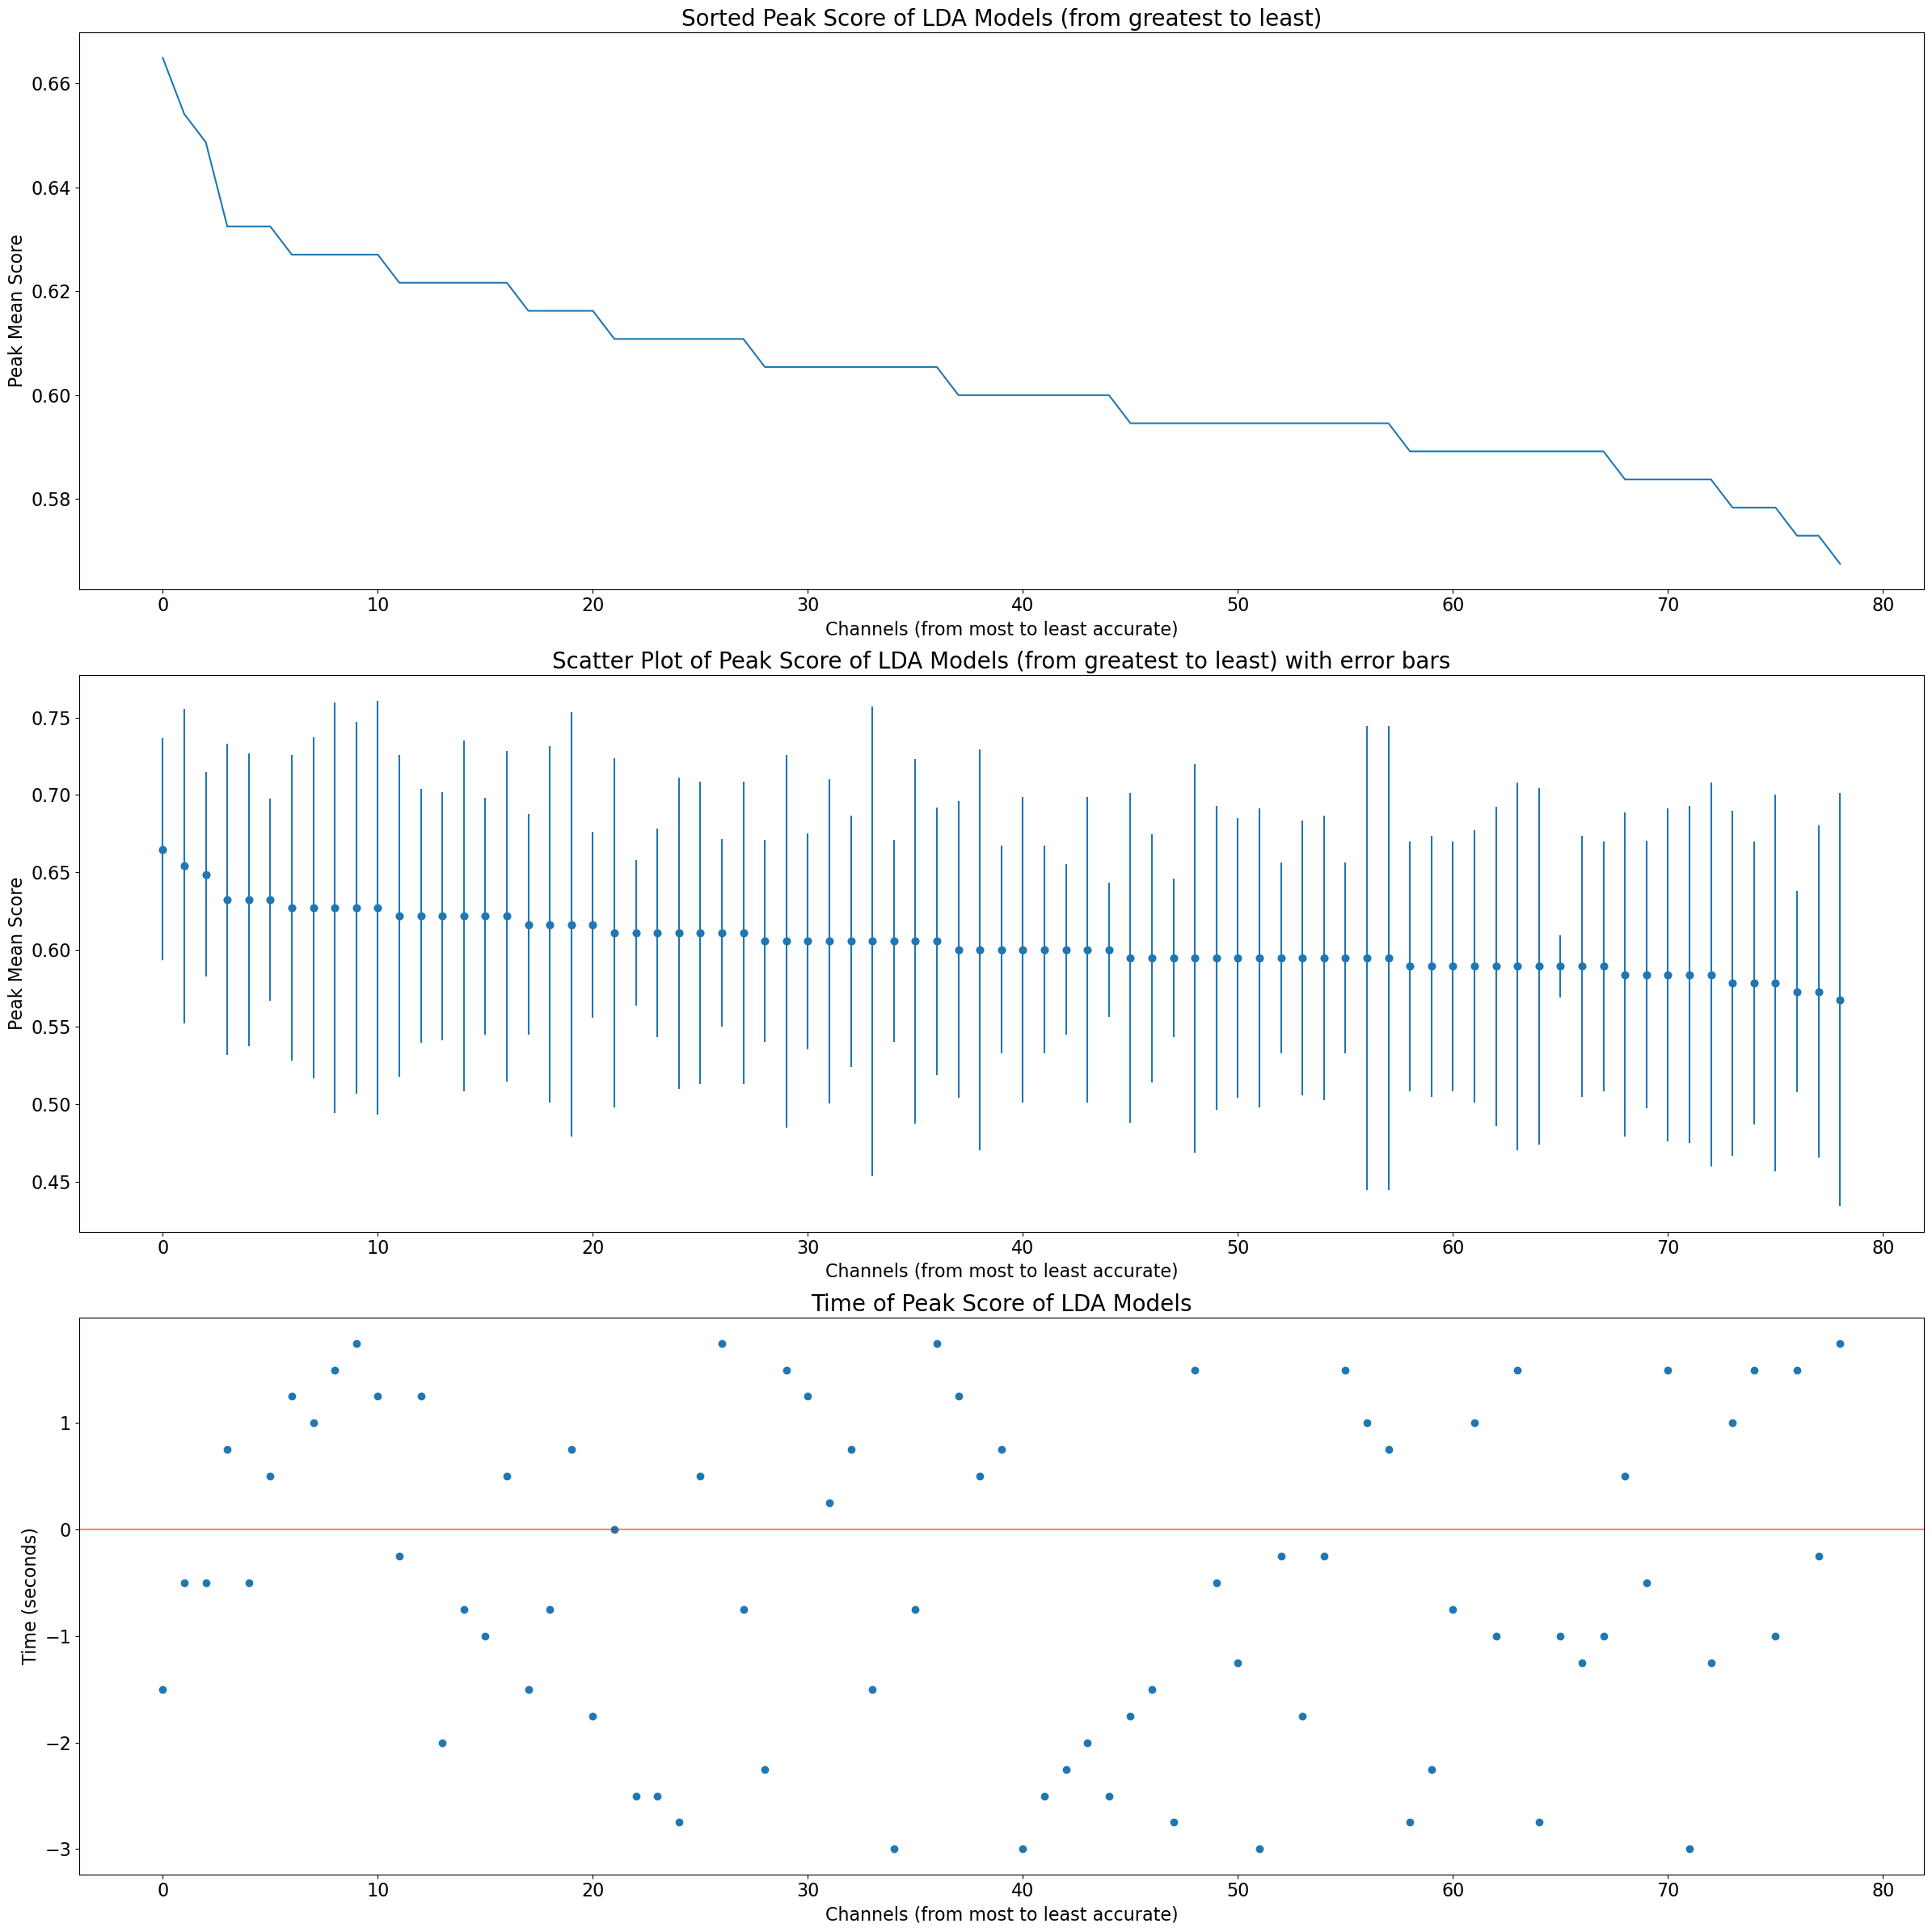

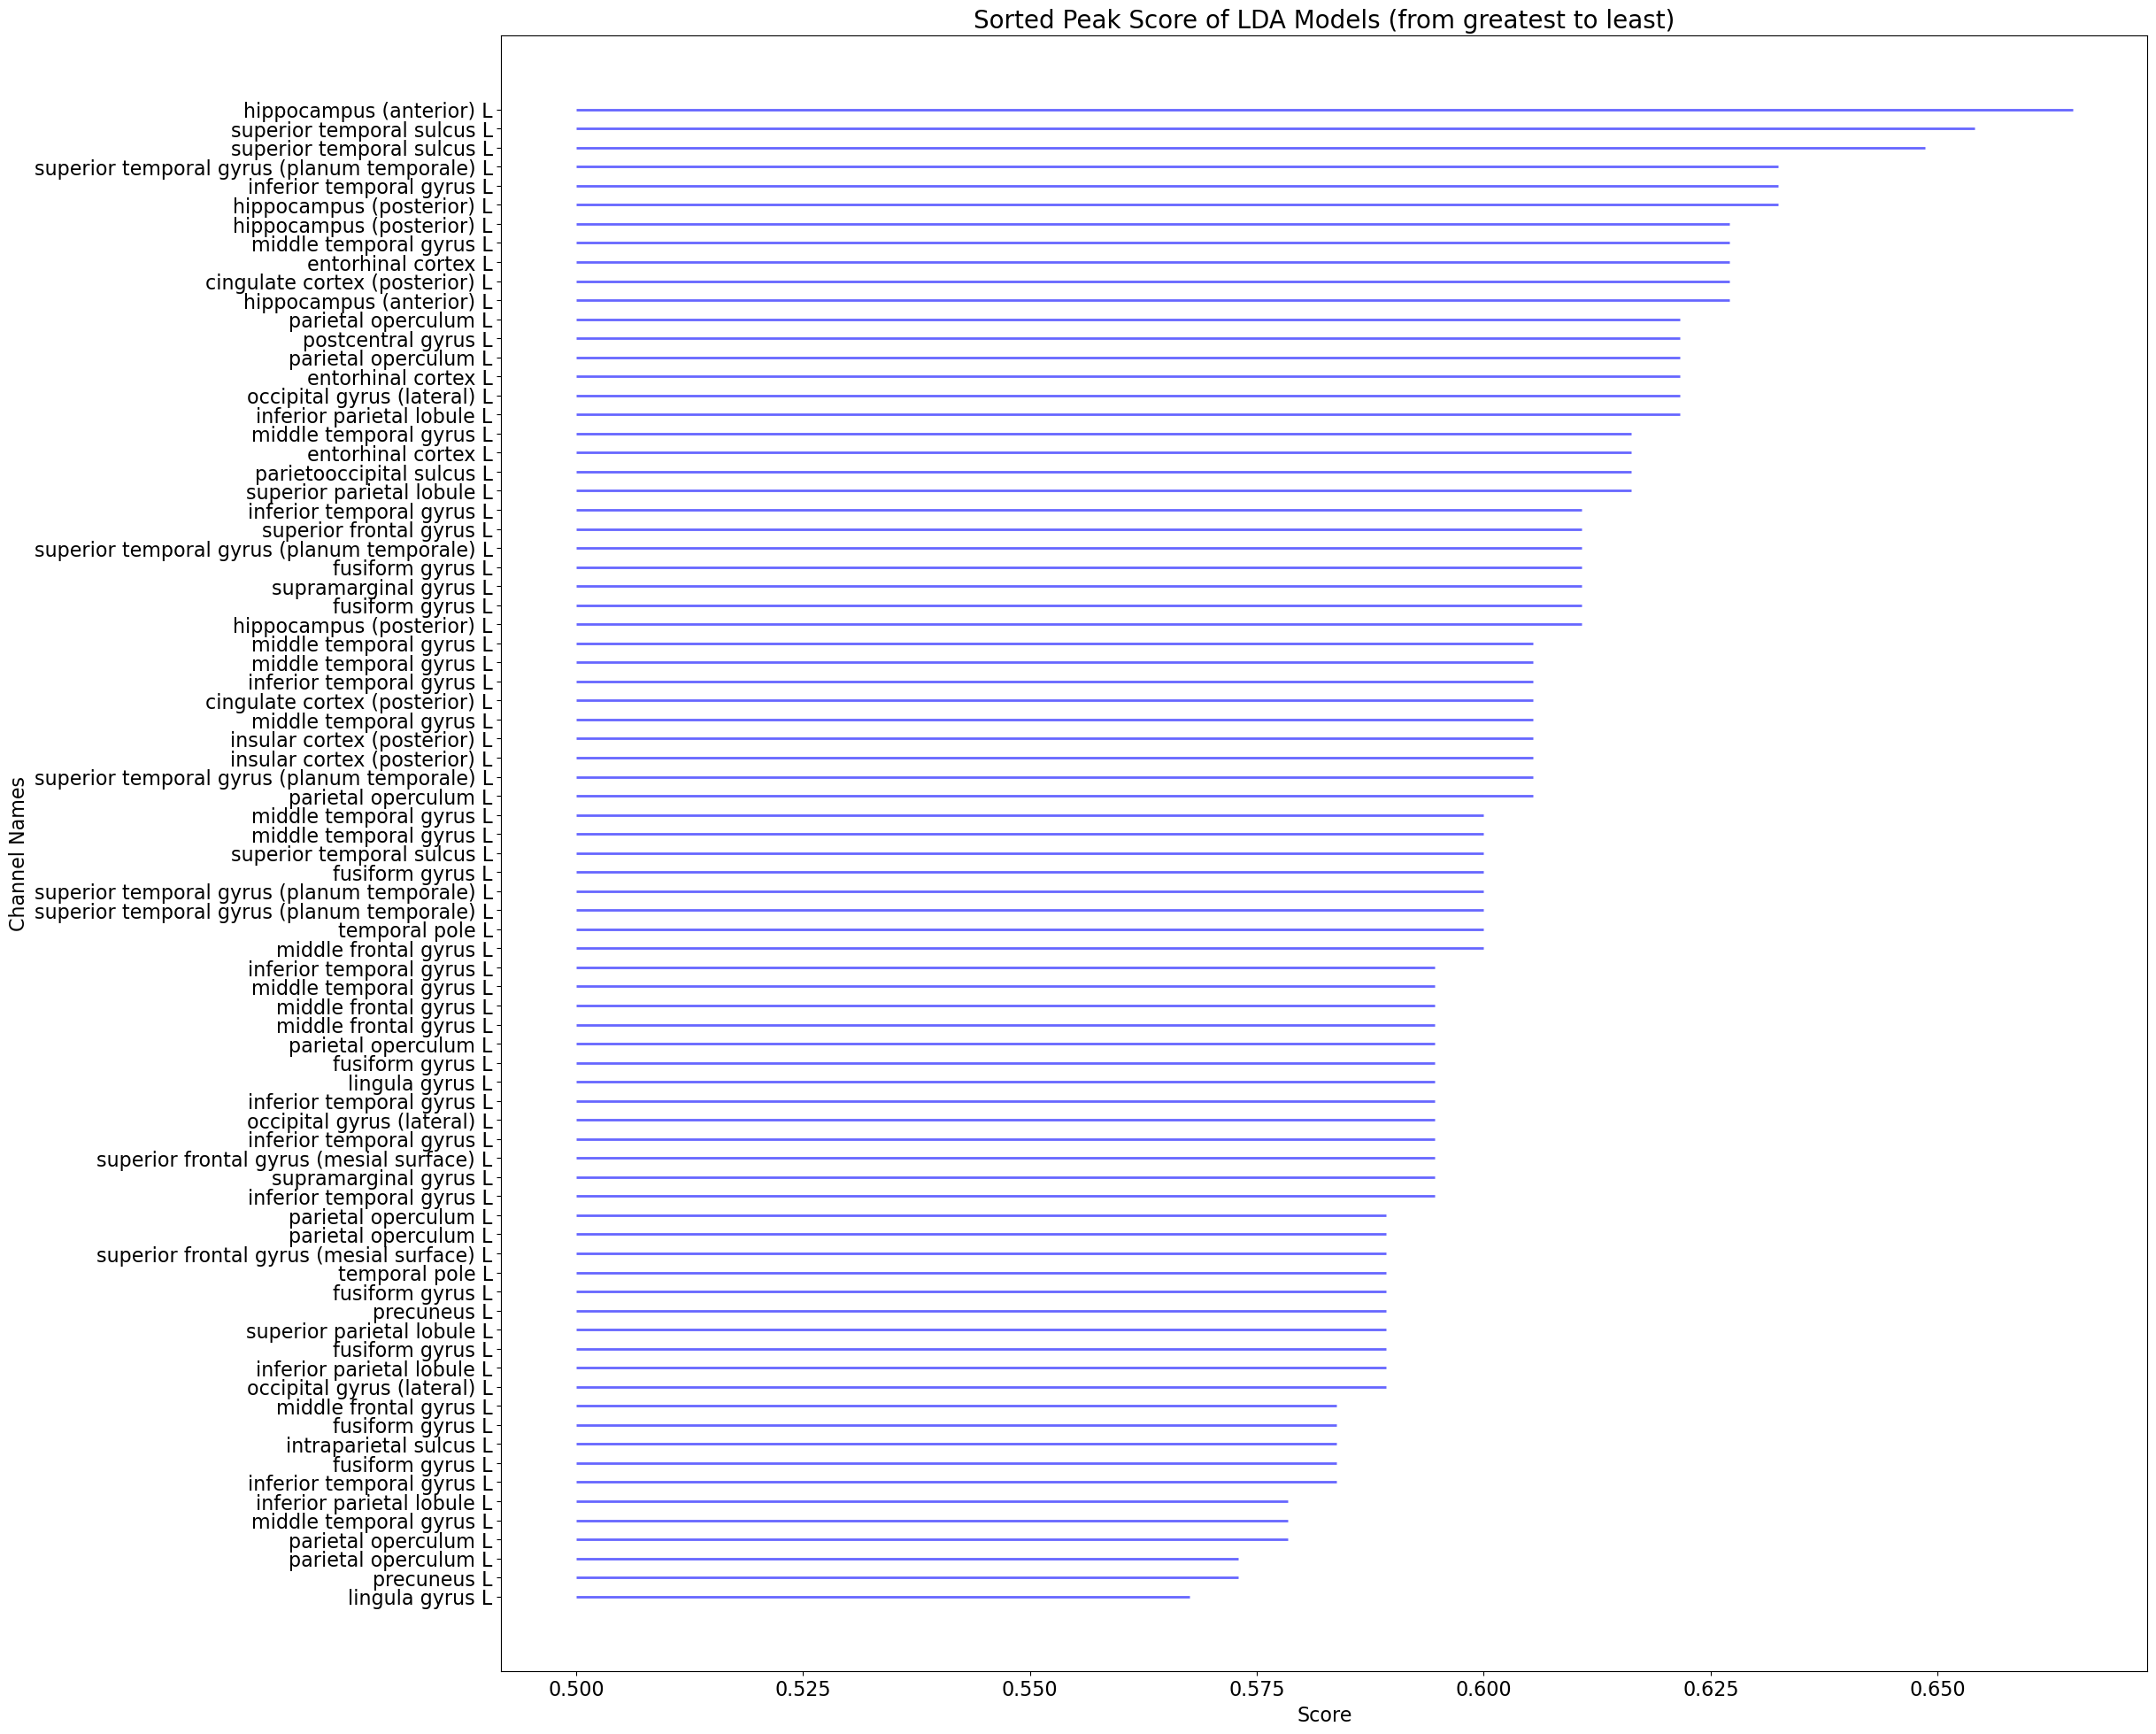

In [100]:
plot_sorted_scores(metrics, mean_scores_max_sorted, elec_areas_sorted, out_path_plots)

### Save Plots

In [20]:
mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted = sort_scores(data,metrics, elec_names, elec_areas, filter_channels=True)

sorted_scores = {
    'Sorted Max Scores' : mean_scores_max_sorted[:,2],
    'Sorted Electrode Names' : elec_names_sorted,
    'Sorted Electrode Areas' : elec_areas_sorted
}

In [21]:
with open(out_path_metrics+'_sorted_scores.csv', 'w', newline="") as fp:
    writer = csv.DictWriter(fp, fieldnames=sorted_scores.keys())
    writer.writeheader()
    writer.writerow(sorted_scores)

## Via Classes

In [22]:
class PerChannelTimestep(object):

    def __init__(
        self,
        estimator,
        filter_channels = False
        ) :
        self.__estimator = estimator

        self._sort_scores(filter_channels)

    def _sort_scores(self, filter_channels:bool):

        max_mean_scores = np.zeros((self.__estimator.num_channels,3))

        for channel in range(self.__estimator.num_channels):
            max_mean_scores[channel, 0] = int(channel) # store the channel index
            max_mean_scores[channel, 1] = list(self.__estimator.mean_scores[channel]).index(max(self.__estimator.mean_scores[channel])) # the time point at which the maximum mean score occurs
            max_mean_scores[channel, 2] = max(self.__estimator.mean_scores[channel]) # value of the maximum mean score in a particular channel for all time points

        if filter_channels == True:
            elec_areas_filtered_idx = [i for i,ea in enumerate(self.__estimator.elec_areas) if ea not in ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid','lesion L','ventricle L','ventricle R']]
            sorted_indices = max_mean_scores[elec_areas_filtered_idx,2].argsort()[::-1]
            self.sorted_max_mean_scores = max_mean_scores[elec_areas_filtered_idx][sorted_indices]
            self.sorted_elec_names = [self.__estimator.elec_names[i] for i in np.int_(self.sorted_max_mean_scores[:, 0])]
            self.sorted_elec_areas = [self.__estimator.elec_areas[i] for i in np.int_(self.sorted_max_mean_scores[:, 0])]
            
        else:
            sorted_indices = max_mean_scores[:,2].argsort()[::-1]
            self.sorted_max_mean_scores = max_mean_scores[sorted_indices]
            self.sorted_elec_names = [self.__estimator.elec_names[i] for i in sorted_indices]
            self.sorted_elec_areas = [self.__estimator.elec_areas[i] for i in sorted_indices]

    def plot_sorted_scores(self, out_path:str):
        num_channels = len(self.sorted_max_mean_scores)
        
        fig, axs = plt.subplots(3, 1, figsize=(24,24), gridspec_kw={'height_ratios' : [1,1,1]})

        axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
        axs[0].set_ylabel('Peak Mean Score')
        axs[0].set_xlabel('Channels (from most to least accurate)')
        axs[0].plot(np.arange(0,num_channels,1), self.sorted_max_mean_scores[:,2])

        axs[1].set_title('Scatter Plot of Peak Score of LDA Models (from greatest to least) with error bars')
        axs[1].set_ylabel('Peak Mean Score')
        axs[1].set_xlabel('Channels (from most to least accurate)')
        axs[1].scatter(np.arange(0,num_channels,1), self.sorted_max_mean_scores[:,2])
        axs[1].errorbar(np.arange(0,num_channels,1), self.sorted_max_mean_scores[:,2], yerr=self.__estimator.std_scores[np.int_(self.sorted_max_mean_scores[:,0]),np.int_(self.sorted_max_mean_scores[:,1])].flatten(), fmt="o")
        
        axs[2].set_title('Time of Peak Score of LDA Models')
        axs[2].set_ylabel('Time (seconds)')
        axs[2].set_xlabel('Channels (from most to least accurate)')
        time = self.sorted_max_mean_scores[:,1]/(20/self.__estimator.time_resolution) - 3
        axs[2].scatter(np.arange(0, num_channels), time)
        axs[2].axhline(y = 0, color = 'red', alpha=0.5)

        fig.tight_layout()
        fig.savefig(out_path + f'_sorted_scores')
        
        plt.figure(figsize=(24,24))
        plt.title('Sorted Peak Score of LDA Models (from greatest to least)')
        plt.ylabel('Channel Names')
        plt.xlabel('Score')
        plt.hlines(y=np.arange(0,num_channels), xmin=0.5, xmax=self.sorted_max_mean_scores[:,2][::-1],
            color='blue', alpha=0.6, linewidth=2)
        plt.yticks(np.arange(0,num_channels), labels=self.sorted_elec_areas[::-1])

        plt.savefig(out_path + f'_sorted_scores_hline')
    
    def plot_sorted_scores_per_channel(self, num_plots:int, out_path:str):
        time_resolution = self.__estimator.time_resolution
        rescaled_timesteps = self.__estimator.rescaled_timesteps
        
        times = (np.arange(0, rescaled_timesteps, 1) / (20/time_resolution)) - 3 # time 0 seconds denotes when the subject starts moving (i.e. 3 seconds into the data)

        fig, axs = plt.subplots(num_plots, 1, figsize=(24, 8 * num_plots))

        for i, trial_data in enumerate(self.sorted_max_mean_scores[:num_plots]):
            channel, time, peak_accuracy = trial_data
            time = time/(20/time_resolution) - 3
            ax = axs[i]
            ax.plot(times[:], self.__estimator.mean_scores[int(channel)])
            ax.set_title('Electrode %s in the %s' %(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            ax.set_ylabel('Score')
            ax.set_xlabel('Time (seconds)')
            # ax.tick_params(axis='both', labelsize=12)
            ax.axvline(time, color = 'red', alpha=0.5)
            ax.axvline(0, color = 'blue', alpha=0.5, ls = '--')
            ax.annotate(f'(Time: {time:.2f}s, Score: {peak_accuracy:.2f})', xy=(time + .05 ,.6), fontsize = 12)
        
        plt.savefig(out_path + f'_sorted_scores_per_channel')
        plt.show()

    def plot_power_heatmap(self, plot_metric, num_plots:int, out_path:str):
        num_freqs = self.__estimator.num_freqs
        time_resolution = self.__estimator.time_resolution
        rescaled_timesteps = self.__estimator.rescaled_timesteps

        if rescaled_timesteps >= 50:
            num_xticks = int(rescaled_timesteps/2)
        else:
            num_xticks = rescaled_timesteps

        xticks = np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)
        xticklabels = np.around(np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - 3, decimals=2)

        if num_freqs == 5: 
            # sets the y-tick labels for EEG frequency bands
            yticks = np.arange(num_freqs)
            yticklabels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
        else:
            # sets the y-tick labels for all frequencies in data
            yticks = np.arange(num_freqs, step=2)
            yticklabels = [round(i,1) for i in np.logspace(np.log2(2),np.log2(150), num = len(yticks),base=2, dtype=np.float16)]

        for i, trial_data in enumerate(self.sorted_max_mean_scores[:num_plots]):
            channel, time, peak_accuracy = trial_data

            low_bet_powers = self.__estimator.low_bet_avg_powers[int(channel)]
            high_bet_powers = self.__estimator.high_bet_avg_powers[int(channel)]
            diff_bet_powers = self.__estimator.diff_avg_powers[int(channel)]
            lda_coef = self.__estimator.lda_coefs[int(channel)]

            fig, axs = plt.subplots(2, 2,figsize=(24, 20))
            
            # Plot power per frequency as a function of time, power averaged across all respective trials (high or low bet trials) 
            sns.heatmap(high_bet_powers.T, ax=axs[0][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
            axs[0][0].set_title('Electrode %s in the %s \n High Bet Z-Scored Frequency Power (n = %s)' %(self.sorted_elec_names[i], self.sorted_elec_areas[i], "~"))
            axs[0][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
            # axs[0][0].set_xticks(xticks, labels = xticklabels)

            sns.heatmap(low_bet_powers.T, ax=axs[0][1], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
            axs[0][1].set_title('Electrode %s in the %s \n Low Bet Z-Scored Frequency Power (n = %s)' %(self.sorted_elec_names[i], self.sorted_elec_areas[i], "~"))
            axs[0][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
            # axs[0][1].set_xticks(xticks, labels = xticklabels)

            # Plot power per frequency at a particular timestep for each respective trial (high or low bet trials)
            # sns.heatmap(low_bet_powers[int(time)].T, ax=axs[0][0], vmin=-3, vmax=3, cbar_kws={"label": "Frequency Power"}, cmap='PRGn')
            # axs[0][0].set_title('Electrode %s in the %s at time %s \n Low Bet Frequency Power' %(elec_names[i], elec_areas[i], round(time/(20/time_resolution) - 3,2)))
            # axs[0][0].set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

            # sns.heatmap(high_bet_powers[int(time)].T, ax=axs[0][1], vmin=-3, vmax=3, cbar_kws={"label": "Frequency Power"}, cmap='PRGn')
            # axs[0][1].set_title('Electrode %s in the %s at time %s \n High Bet Frequency Power' %(elec_names[i], elec_areas[i], round(time/(20/time_resolution) - 3,2)))
            # axs[0][1].set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

            # Plots the difference in power frequency for high and low bet trials
            sns.heatmap(diff_bet_powers.T, ax=axs[1][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power", "pad": 0.1}, cmap='PRGn')
            axs[1][0].set_title('Electrode %s in the %s \n Difference in Z-Scored Frequency Power (High - Low Bet)' %(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            axs[1][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
            # axs[1][0].set_xticks(xticks, labels = xticklabels)
            ax = axs[1][0].twinx()
            sns.lineplot(x=np.arange(0,rescaled_timesteps), y=plot_metric[int(channel)].flatten(), color='blue', ax=ax) # Make the overlayed metric an optional variable user can select
            ax.set_ylabel('Mean LDA Score')
            axs[1][0].axvline(time, color = 'red', alpha=0.5)
            axs[1][0].axvline(0, color = 'blue', alpha=0.25, ls = '--')

            # Plots the LDA coefficients for each frequency band over time
            sns.heatmap(lda_coef.T, ax=axs[1][1], vmin=-1, vmax=1, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
            axs[1][1].set_title('LDA coefficient values for all frequencies \n at %s in %s' %(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            axs[1][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
            # axs[1][1].set_xticks(xticks, labels = xticklabels)

            for axs_ in axs:
                for ax in axs_:
                    ax.set_xticks(xticks, labels = xticklabels)
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(yticklabels, rotation = 0)
                    ax.axes.invert_yaxis()
                    ax.axvline(time, color = 'red', alpha=0.5)
                    ax.axvline(12, color = 'blue', alpha=0.5, ls = '--')

                    for label in ax.xaxis.get_ticklabels()[1::2]:
                        label.set_visible(False)

            plt.savefig(out_path + '_heatmap_%s_%s'%(self.sorted_elec_names[i], self.sorted_elec_areas[i]))
            plt.show()

In [115]:
class PerTimestepAllChannels(object):

    def __init__(
        self,
        estimator
        ) :
        self.__estimator = estimator

        self._sort_scores()
        self._convert_timesteps_to_time(3)
        
    def _sort_scores(self):

        enumerated_mean_scores = np.array(list(enumerate(self.__estimator.mean_scores.flatten())))
        sorted_indices = enumerated_mean_scores[:,1].argsort()[::-1]
        self.sorted_mean_scores = enumerated_mean_scores[sorted_indices]

    def _convert_timesteps_to_time(self, event_delay):
        self.__event_delay = event_delay
        self.__times = (np.arange(0, self.__estimator.rescaled_timesteps) / (20/self.__estimator.time_resolution)) - event_delay # time 0 seconds denotes when the subject starts moving (i.e. 3 seconds into the data)

    
    def plot_sorted_scores(self, out_path:str):
        num_timesteps = self.__estimator.rescaled_timesteps
        xticks = np.arange(0,num_timesteps,1)
        
        fig, axs = plt.subplots(3, 1, figsize=(24,24), gridspec_kw={'height_ratios' : [1,1,1]})

        axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
        axs[0].set_ylabel('Mean Score')
        axs[0].set_xlabel('Times (from most to least accurate)')
        axs[0].set_xticks(xticks, labels = self.__times[np.int_(self.sorted_mean_scores[:,0])])
        axs[0].plot(xticks ,self.sorted_mean_scores[:,1])

        axs[1].set_title('Scatter Plot of Peak Score of LDA Models (from greatest to least) with error bars')
        axs[1].set_ylabel('Mean Score')
        axs[1].set_xlabel('Times (from most to least accurate)')
        axs[1].set_xticks(xticks, labels = self.__times[np.int_(self.sorted_mean_scores[:,0])])
        axs[1].scatter(xticks, self.sorted_mean_scores[:,1])
        axs[1].errorbar(xticks, self.sorted_mean_scores[:,1], yerr=self.__estimator.std_scores[np.int_(self.sorted_mean_scores[:,0])].flatten(), fmt="o")

        axs[2].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
        axs[2].set_ylabel('Times (from most to least accurate)')
        axs[2].set_xlabel('Score')
        axs[2].hlines(y=np.arange(0,num_timesteps), xmin=0.5, xmax=self.sorted_mean_scores[:,1][::-1],
            color='blue', alpha=0.6, linewidth=2)
        axs[2].set_yticks(np.arange(0,num_timesteps), labels=self.__times[np.int_(self.sorted_mean_scores[:,0])][::-1])

        fig.tight_layout()
        fig.savefig(out_path + '_sorted_scores_per_timestep_all_channels')
    
    def plot_power_heatmap(self, out_path:str):

        num_freqs = self.__estimator.num_freqs
        time_resolution = self.__estimator.time_resolution
        rescaled_timesteps = self.__estimator.rescaled_timesteps

        low_bet_powers = self.__estimator.low_bet_avg_powers
        high_bet_powers = self.__estimator.high_bet_avg_powers
        diff_bet_powers = self.__estimator.diff_avg_powers
        lda_coef = self.__estimator.lda_coefs

        if rescaled_timesteps >= 50:
            num_xticks = int(rescaled_timesteps/2)
        else:
            num_xticks = rescaled_timesteps

        if num_freqs == 5: 
            # sets the y-ticks when using EEG frequency bands
            yticks = np.arange(diff_bet_powers.shape[1], step=5)
        else:
            # sets the y-ticks when using all frequencies in data
            yticks = np.arange(diff_bet_powers.shape[1], step=63)
            # yticklabels = [round(i,1) for i in np.logspace(np.log2(2),np.log2(150), num = len(yticks),base=2, dtype=np.float16)]

        xticks = np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)
        xticklabels = np.around(np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - self.__event_delay, decimals=2)

        fig, axs = plt.subplots(2, 2,figsize=(24, 20))
        
        # Plot power per frequency as a function of time, power averaged across all respective trials (high or low bet trials) 
        sns.heatmap(high_bet_powers.T, ax=axs[0][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[0][0].set_title('High Bet Z-Scored Frequency Power (n = %s)' %("~"))
        axs[0][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

        sns.heatmap(low_bet_powers.T, ax=axs[0][1], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[0][1].set_title('Low Bet Z-Scored Frequency Power (n = %s)' %("~"))
        axs[0][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

        # Plots the difference in power frequency for high and low bet trials
        sns.heatmap(diff_bet_powers.T, ax=axs[1][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Z-Scored Frequency Power", "pad": 0.1}, cmap='PRGn')
        axs[1][0].set_title('Difference in Z-Scored Frequency Power (High - Low Bet)')
        axs[1][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        ax = axs[1][0].twinx()
        sns.lineplot(x=np.arange(0,rescaled_timesteps), y=self.__estimator.mean_scores.flatten(), color='blue', ax=ax) # Make the overlayed metric an optional variable user can select
        ax.set_ylabel('Mean LDA Score')

        # Plots the LDA coefficients for each frequency band over time
        sns.heatmap(lda_coef.T, ax=axs[1][1], vmin=-1, vmax=1, cbar_kws={"label": "Z-Scored Frequency Power"}, cmap='PRGn')
        axs[1][1].set_title('LDA coefficient values for all frequencies')
        axs[1][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

        for axs_ in axs:
            for ax in axs_:
                ax.set_xticks(xticks, labels = xticklabels, rotation = 90)
                ax.set_yticks(yticks)
        #        ax.set_yticklabels(yticklabels, rotation = 0)
                ax.axes.invert_yaxis()
                ax.axvline(self.sorted_mean_scores[0,0], color = 'red', alpha=0.5)
                ax.axvline(12, color = 'blue', alpha=1, ls = '--')

                for label in ax.xaxis.get_ticklabels()[1::2]:
                    label.set_visible(False)

        plt.savefig(out_path + '_heatmap_per_timestep_all_channels')
        plt.show()

    def plot_contributing_channels(self, alpha):
        num_freqs = self.__estimator.num_freqs
        time_resolution = self.__estimator.time_resolution
        rescaled_timesteps = self.__estimator.rescaled_timesteps

        if rescaled_timesteps >= 50:
            num_xticks = int(rescaled_timesteps/2)
        else:
            num_xticks = rescaled_timesteps
        
        yticks = np.arange(num_freqs)
        yticklabels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

        xticks = np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)
        xticklabels = np.around(np.linspace(0, rescaled_timesteps - 1, num=num_xticks, dtype=np.int_)/(20/time_resolution) - self.__event_delay, decimals=2)


        avg_coefs = np.abs(self.__estimator.lda_coefs).mean(0)
        idxs = []

        for i in avg_coefs.argsort()[::-1]:
            if avg_coefs[i] > alpha:
                idxs.append(i)
            else:
                break
        
        channels = [int(i/self.__estimator.num_freqs) for i in idxs]

        fig, axs = plt.subplots(len(idxs), 1, figsize=(12,7*len(idxs)))

        for i, ch in enumerate(channels):
            ch_idx = ch*self.__estimator.num_freqs
            sns.heatmap(self.__estimator.lda_coefs.T[ch_idx:ch_idx+self.__estimator.num_freqs], ax=axs[i], cmap='PRGn')

            axs[i].set_xticks(xticks, labels = xticklabels, rotation = 90)
            axs[i].set_xlabel('Time (seconds)')
            axs[i].set_yticklabels(yticklabels, rotation = 0)
            axs[i].set_ylabel('Frequency Band')
            axs[i].axes.invert_yaxis()
            axs[i].axvline(self.sorted_mean_scores[0,0], color = 'red', alpha=0.5)
            axs[i].axvline(12, color = 'blue', alpha=1, ls = '--')
            axs[i].set_title('Electrode %s in the %s \n LDA Coefficients' %(self.__estimator.elec_names[ch], self.__estimator.elec_areas[ch]))

        plt.tight_layout()

In [116]:
visualizer = PerTimestepAllChannels(lda)

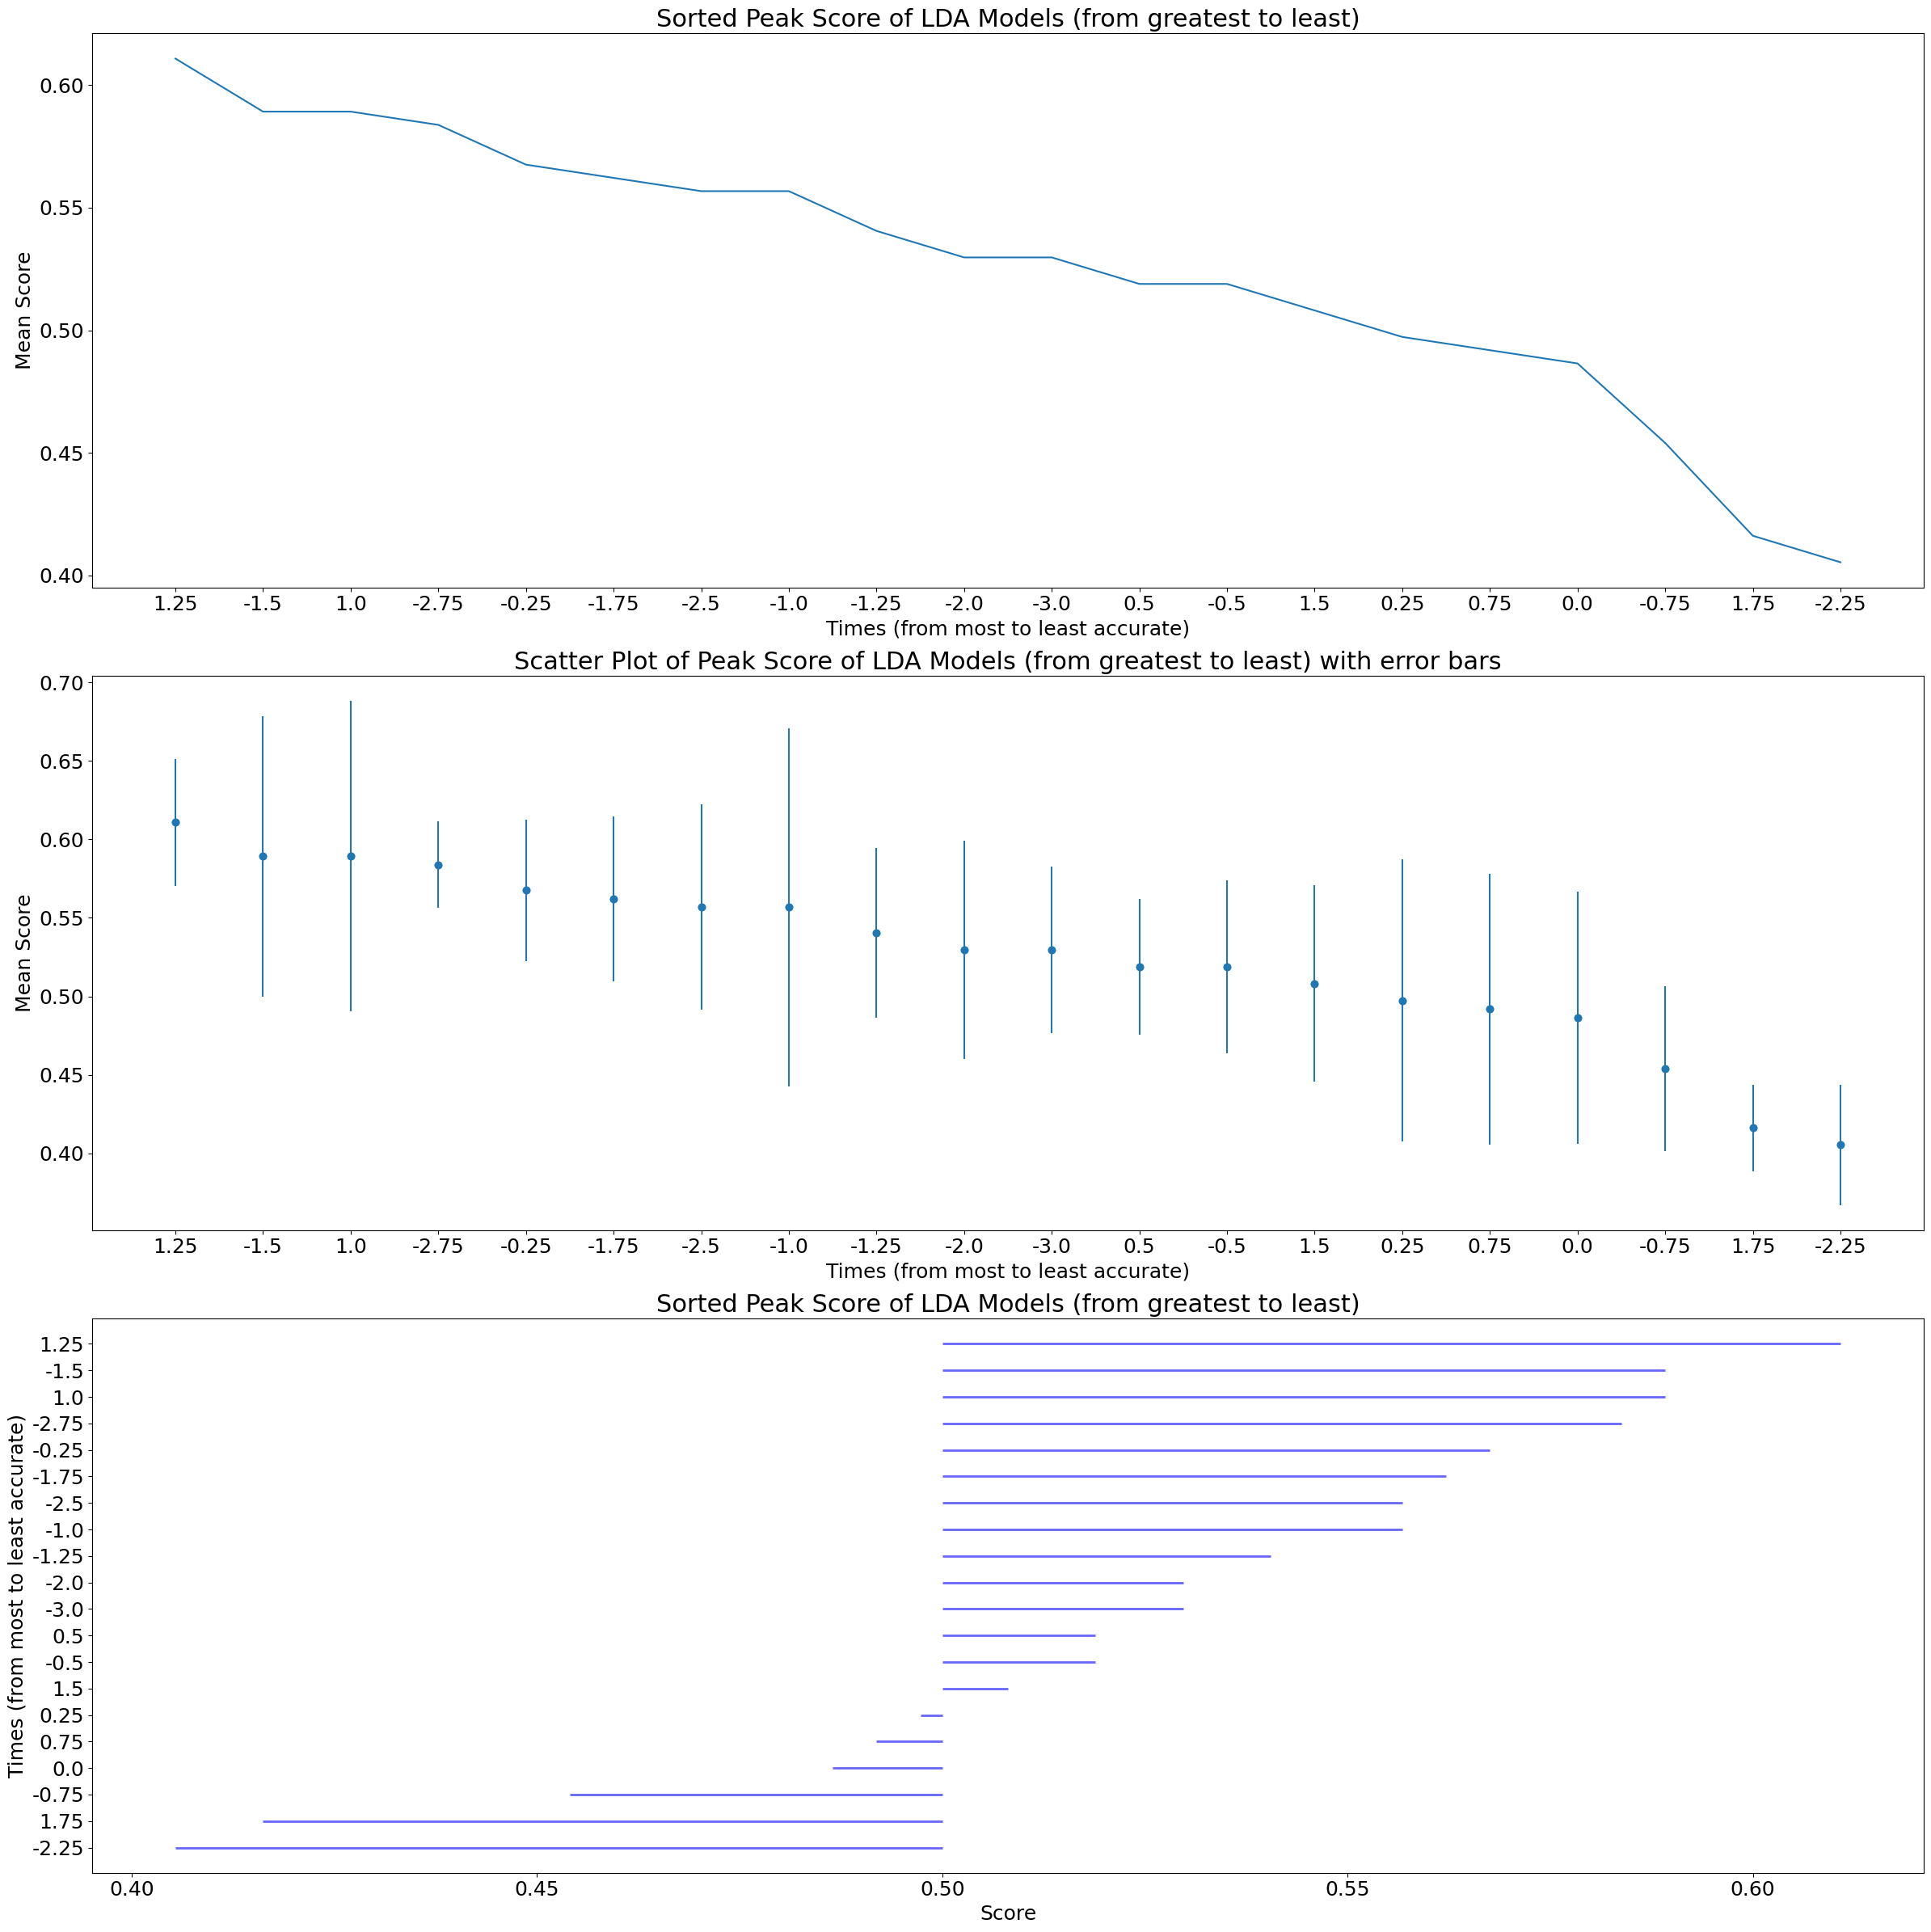

In [120]:
visualizer.plot_sorted_scores(out_path_plots)

# Extraneous Code